# Table of Contents:  

### 1. Importing your libraries and data  
### 2. Subsetting, wrangling, and cleaning time-series data  
### 3. Time series analysis: decomposition  
### 4. Testing for stationarity  
### 5. Stationarizing the Federal Reserve Economic Data  

## 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'QYmYbLc-Kf-Xh8EBC9zt'

In [3]:
# Importing the Federal Reserve Economic Data "Real Potential Gross Domestic Product" variable.

data = quandl.get('FRED/GDPPOT')

In [4]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [6]:
data.shape

(332, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

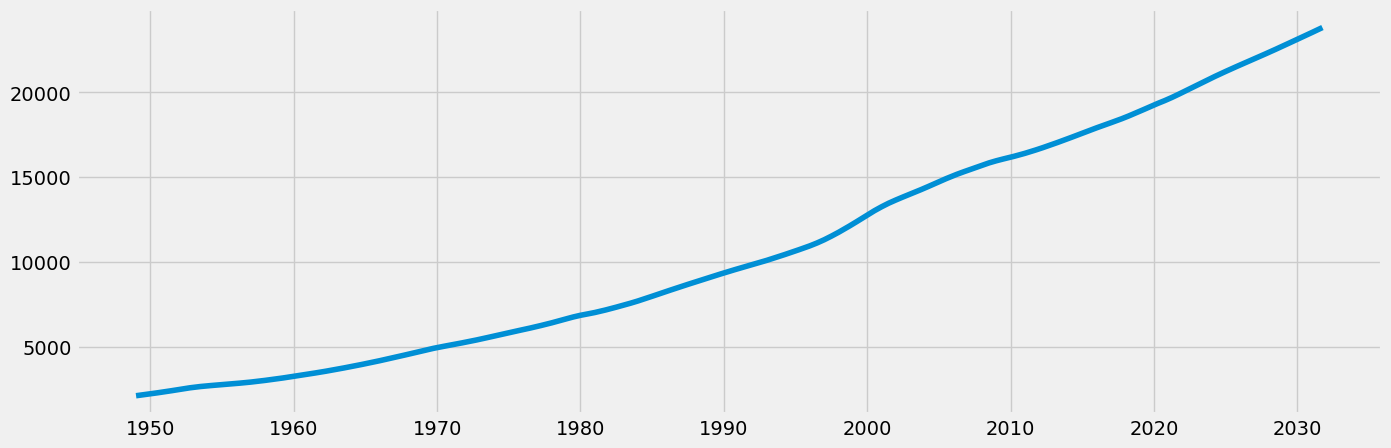

In [10]:
# Plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

## 2. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [13]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [15]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2023-06-01')]

In [16]:
data_sub.shape

(174, 2)

In [18]:
data_sub.tail()

,Date,Value
293,2022-04-01,20109.88
294,2022-07-01,20216.09
295,2022-10-01,20321.48
296,2023-01-01,20425.71
297,2023-04-01,20529.61


In [19]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6847.481683
1980-04-01,6890.146039
1980-07-01,6928.061362
1980-10-01,6968.010712
1981-01-01,7012.104757


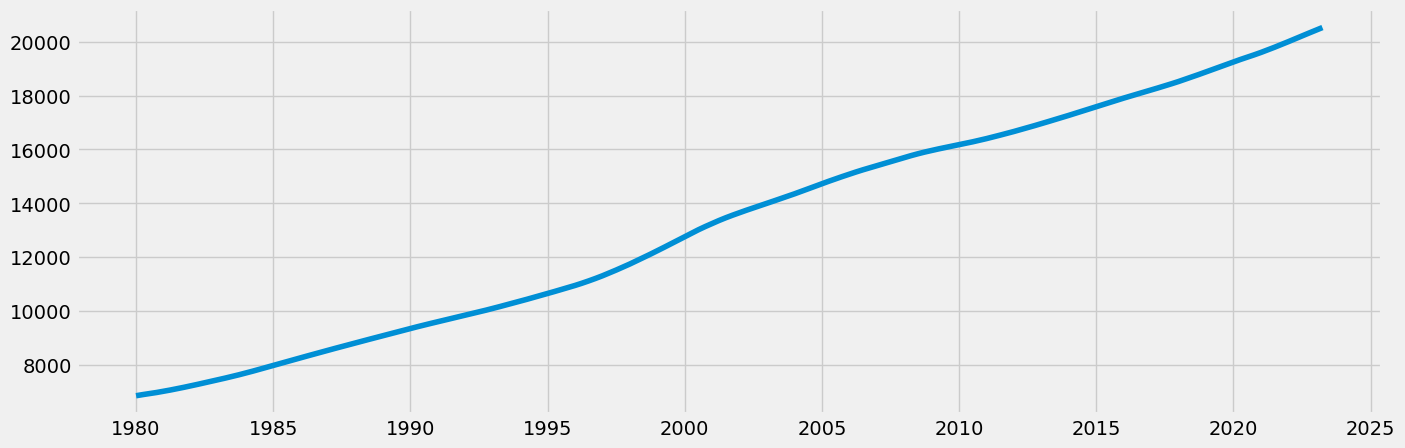

In [20]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [21]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [22]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

## 3. Time-series analysis: decomposition

In [23]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [25]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

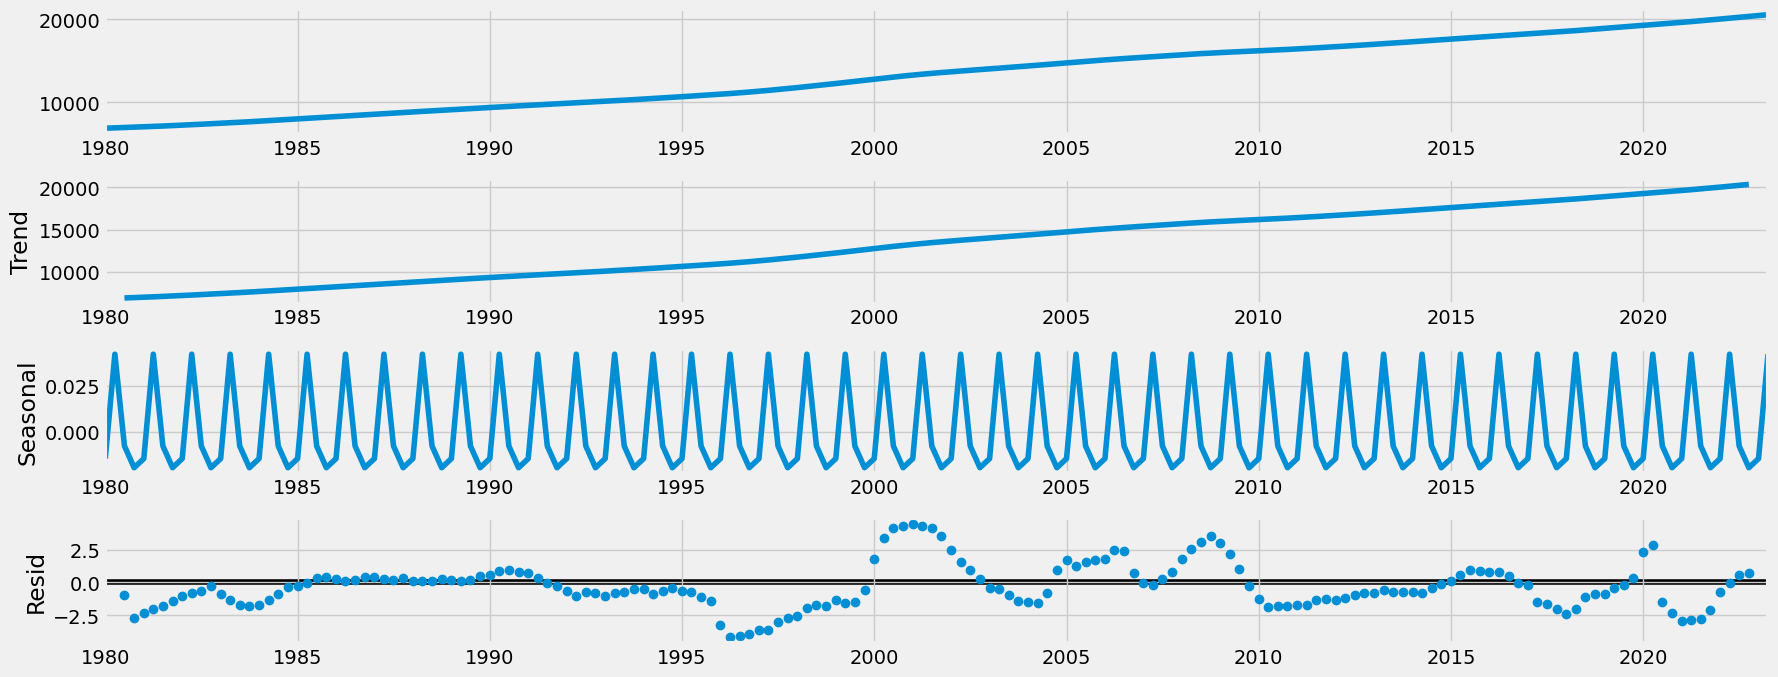

In [26]:
# Plot the separate components

decomposition.plot()
plt.show()

## 4. Testing for stationarity

In [27]:
# Perform the Dicky Fuller Test

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.491782
p-value                          0.984621
Number of Lags Used              2.000000
Number of Observations Used    171.000000
Critical Value (1%)             -3.469181
Critical Value (5%)             -2.878595
Critical Value (10%)            -2.575863
dtype: float64


**Critical Value (5%) -2.878595 is much smaller than Test Statistic 0.491782 which means there is a unit root in the data, and the data is non-stationary.**

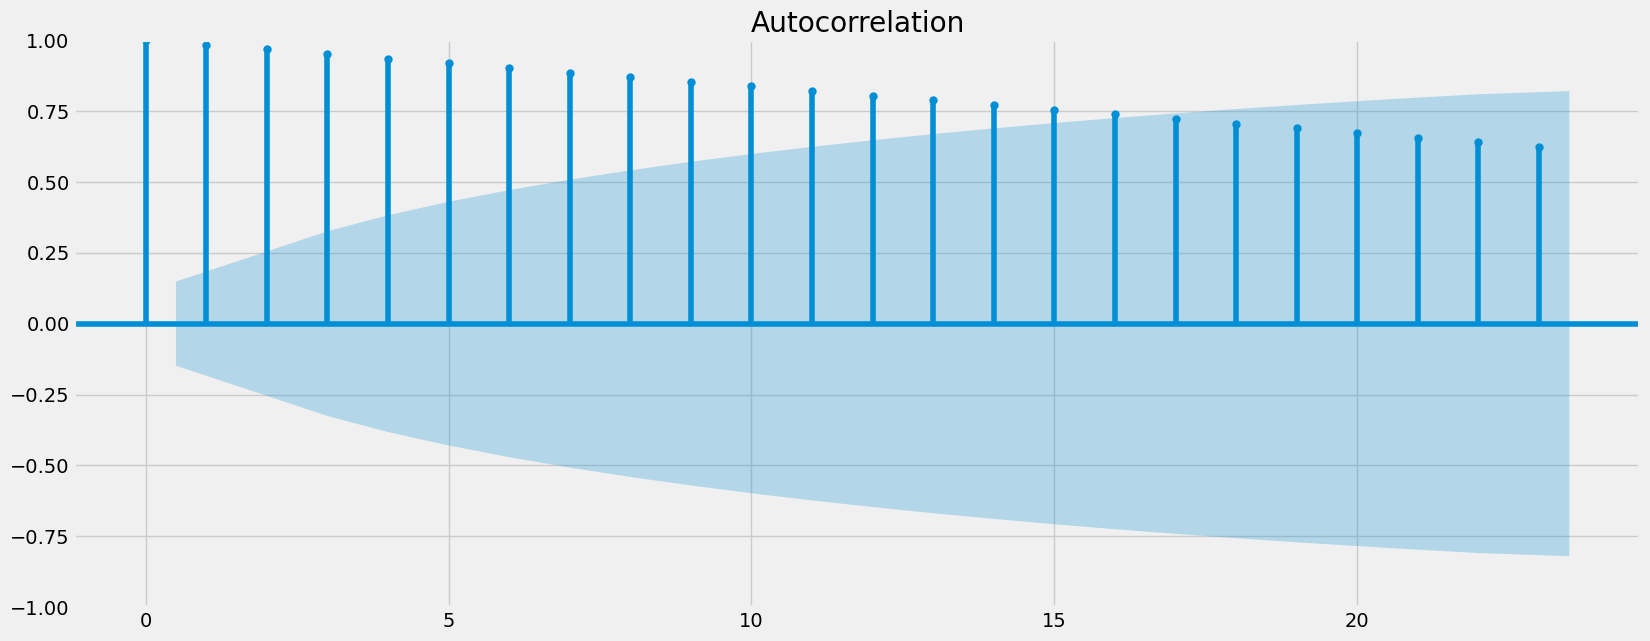

In [28]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

**The lines go above the blue edge of the confidence interval, this means the lags that are significantly correlated with each other and there’s a lot of autocorrelated data showing the set is non-stationary**

## 5. Stationarizing the Federal Reserve Economic Data

In [29]:
# Conduct Differencing

data_diff = data_sub - data_sub.shift(1)

In [31]:
# Remove the missing values that were a result of differencing

data_diff.dropna(inplace = True)

In [32]:
data_diff.head()

,Value
datetime,
1980-04-01,42.664356
1980-07-01,37.915323
1980-10-01,39.949350
1981-01-01,44.094045
1981-04-01,47.180044


In [33]:
data_diff.columns

Index(['Value'], dtype='object')

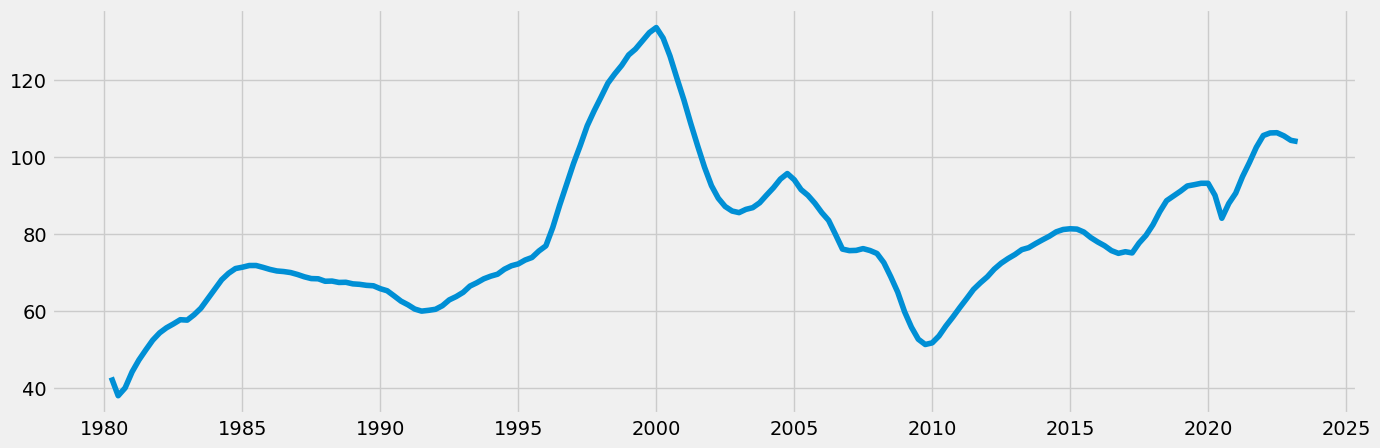

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [35]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.630122
p-value                          0.005211
Number of Lags Used              1.000000
Number of Observations Used    171.000000
Critical Value (1%)             -3.469181
Critical Value (5%)             -2.878595
Critical Value (10%)            -2.575863
dtype: float64


**The test statistic is now smaller than the critical value at both the five and ten percent significance levels. Also p-value is<0.05. This means that we can reject the null hypothesis and, as a result, consider the series stationary**

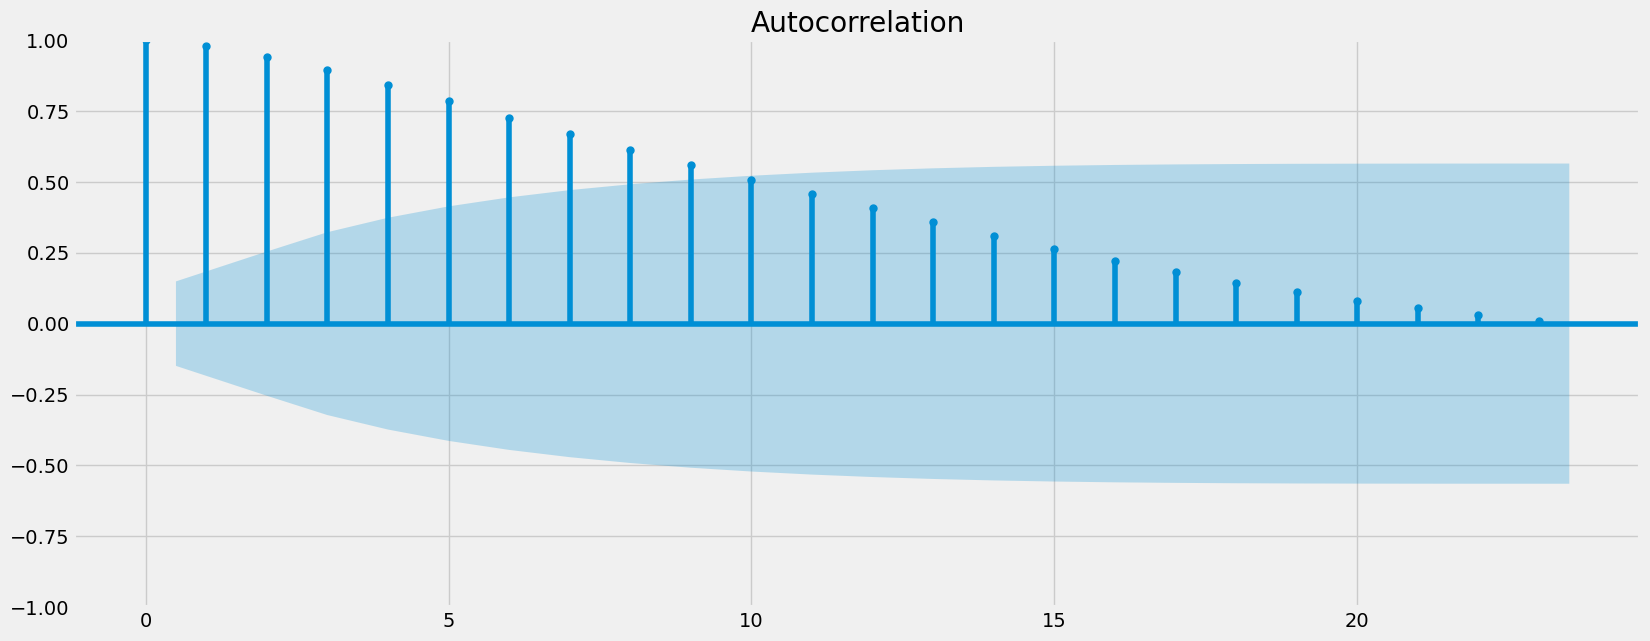

In [36]:
plot_acf(data_diff)
plt.show()

**Since there are still 10 vertical lines above the confidence llevel so we can conduct another round of differencing**

**-- Second Round of Differencing**

In [37]:
# Conduct Differencing

data_diff_1 = data_diff - data_diff.shift(1)

In [38]:
# Remove the missing values that were a result of differencing

data_diff_1.dropna(inplace = True)

In [39]:
data_diff_1.head()

,Value
datetime,
1980-07-01,-4.749033
1980-10-01,2.034027
1981-01-01,4.144695
1981-04-01,3.085999
1981-07-01,2.617202


In [41]:
data_diff_1.columns

Index(['Value'], dtype='object')

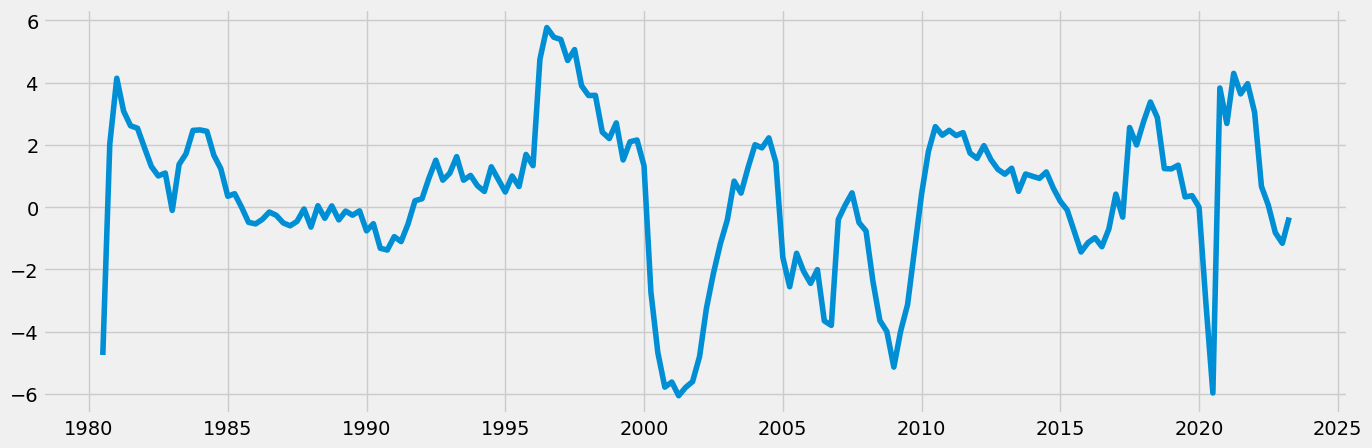

In [42]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_1)

In [43]:
dickey_fuller(data_diff_1)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.413067
p-value                          0.000281
Number of Lags Used              3.000000
Number of Observations Used    168.000000
Critical Value (1%)             -3.469886
Critical Value (5%)             -2.878903
Critical Value (10%)            -2.576027
dtype: float64


**The test statistic is smaller than the critical value. Also p-value is much <0.05. This means that we can reject the null hypothesis and, as a result, consider the series stationary**

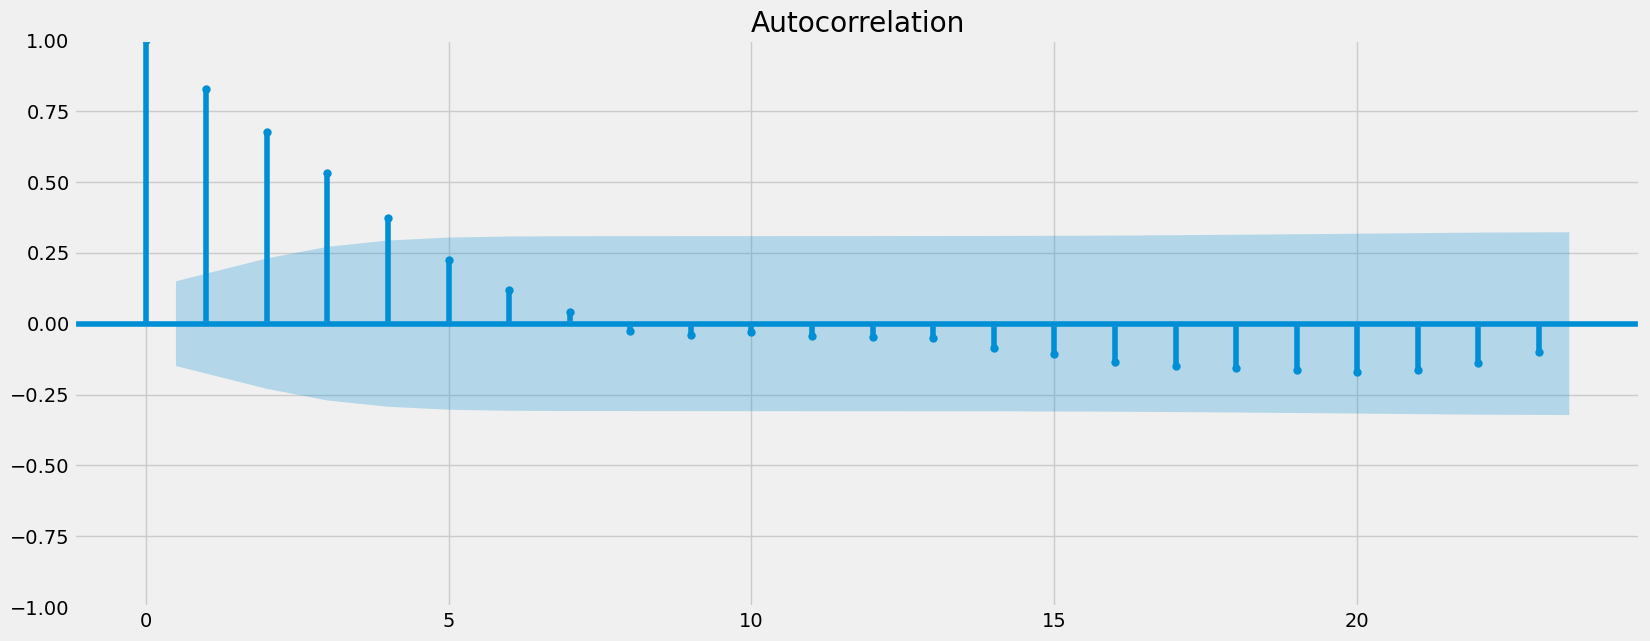

In [44]:
plot_acf(data_diff_1)
plt.show()

**The correlation plot looks better and less than 10 vertical lines are above the confidence level so no more differencing required.**